# Baseline model - simple MLP


Imports:

In [1]:
import copy
import pandas as pd
import numpy as np
import pathlib
import os
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

SEED = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

read data:

In [2]:
df_hard = pd.read_excel('all_data_long.xlsx')

In [3]:
df_hard['Fictive ID'].nunique()

36240

In [4]:
all_df = copy.deepcopy(df_hard)
all_df.columns = all_df.columns.str.replace("'", "")

features_to_start = ['year', 'מין', 'סוג פיקוח', ' פסיכומטרי רב תחומי', 'פסיכומטרי כמותי', 'פסיכומטרי מילולי',
               'שפת פסיכומטרי', 'בגרות', 'ציון מכינה', 'ניקוד רל"ק', 'שנת לידה', 'פקולטה', 'חוג', 'מסלול', 'משקולל קיים', 'נשר חיצונית']

df = all_df[features_to_start]

feature_names_to_replace = {"מין": "gender", 'סוג פיקוח': 'supervision_type',
                        ' פסיכומטרי רב תחומי': 'psico_rav', 'פסיכומטרי כמותי':'psico_camul',
                        'פסיכומטרי מילולי':'psico_verb', 'שפת פסיכומטרי': 'psico_leng',
                        'בגרות':'bag', 'ציון מכינה':'preparatory_score', 'ניקוד רל"ק':'ralak_score',
                        'שנת לידה':'birth_year', 'פקולטה':'faculty',
                        'חוג':'hug', 'מסלול':'study_track', 'משקולל קיים':'weighted_score', 'נשר חיצונית':'dropouts'}

df = df.rename(columns=feature_names_to_replace)

features_to_start_id = features_to_start.copy()
features_to_start_id.append('Fictive ID')
df_id = all_df[features_to_start_id]
df_id = df_id.rename(columns=feature_names_to_replace)

split to train and test:

In [5]:
def split_train_test(df):
    X = df.drop('dropouts', axis=1)
    Y = df['dropouts'].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=SEED)
    
    # Reset indices for compatibility
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = pd.Series(y_train).reset_index(drop=True)
    y_test = pd.Series(y_test).reset_index(drop=True)
    return X_train, X_test, y_train, y_test

build base model:

In [6]:
class DropuotsDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'features': torch.tensor(self.features.iloc[idx].values, dtype=torch.float32),
            'label': torch.tensor(self.labels[idx], dtype=torch.float32)
        }


In [7]:
class BaseModelNN(nn.Module):
    def __init__(self, input_dim):
        super(BaseModelNN, self).__init__()
        
        # Fully connected layers
        self.fc1 = nn.Linear(input_dim, 12)
        self.fc2 = nn.Linear(12, 6)
        self.output = nn.Linear(6, 1)

    def forward(self, features):
        x = torch.relu(self.fc1(features))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.output(x))  # For binary classification
        return x

training loop:

In [8]:
def train_model(model, train_loader, criterion, optimizer, epochs, device):
    model.to(device)  # Move model to the specified device (CPU or GPU)

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        
        for batch in train_loader:
            # Move data to the same device as the model
            features = batch['features'].to(device)
            labels = batch['label'].to(device).view(-1, 1)  # Ensure labels are shaped as (batch_size, 1)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(features)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate the loss
            running_loss += loss.item()

        # Calculate average loss for the epoch
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

    print("Training complete.")

## Baseline:

take only numeric features, drop duplicates:

In [9]:
numeric_features = df.select_dtypes(include=['number']).columns
# drop hug column:
numeric_features = numeric_features[~numeric_features.str.fullmatch('hug')]
# drop duplicates
numeric_df = df[numeric_features].drop_duplicates()
# train test split:
X_train, X_test, y_train, y_test = split_train_test(numeric_df)

In [10]:
# Create DataLoader
batch_size = 32
train_dataset = DropuotsDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = DropuotsDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

initialize model and optimizer:

In [11]:
model = BaseModelNN(input_dim=X_train.shape[1])
criterion = nn.BCELoss()  # For binary classification
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

train:

In [12]:
train_model(model, train_loader, criterion, optimizer, epochs=10, device=device)

Epoch [1/10], Loss: 11.8434
Epoch [2/10], Loss: 5.4096
Epoch [3/10], Loss: 5.4108
Epoch [4/10], Loss: 5.4096
Epoch [5/10], Loss: 5.4108
Epoch [6/10], Loss: 5.4104
Epoch [7/10], Loss: 5.4108
Epoch [8/10], Loss: 5.4100
Epoch [9/10], Loss: 5.4100
Epoch [10/10], Loss: 5.4100
Training complete.


evaluation:

In [14]:

def evaluate_model(model, data_loader, criterion, device, threshold=0.05):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    all_labels = []
    all_predictions = []
    all_probs = []

    with torch.no_grad():
        for batch in tqdm(data_loader):
            # Move data to the same device as the model
            features = batch['features'].to(device)
            labels = batch['label'].to(device).view(-1, 1)

            # Forward pass
            outputs = model(features)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Get predictions and probabilities
            probabilities = outputs.squeeze().cpu().numpy()  # Convert to numpy array
            predictions = (probabilities >= threshold).astype(int)  # Threshold for binary classification
            labels = labels.cpu().numpy()  # Convert labels to numpy

            # Store results
            all_labels.extend(labels)
            all_predictions.extend(predictions)
            all_probs.extend(probabilities)

    # Compute average loss
    avg_loss = total_loss / len(data_loader)

    # Calculate evaluation metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    roc_auc = roc_auc_score(all_labels, all_probs)

    print(f"Evaluation Results:")
    print(f"Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

    return {'loss': avg_loss,
            'accuracy_score': accuracy,
            'precision_score': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': roc_auc,
            'lables': all_labels,
            'predictions': all_predictions,
            'probabilities': all_probs}


In [15]:
test_eval_results = evaluate_model(model, test_loader, criterion, device)

100%|██████████| 264/264 [00:00<00:00, 278.07it/s]
c:\Users\nadavkat\OneDrive - Intel Corporation\Documents\Learning\University\University-Dropouts-Prediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluation Results:
Loss: 5.6593
Accuracy: 0.9434
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
ROC AUC: 0.5000


In [16]:
np.unique(test_eval_results['probabilities'])

array([0.], dtype=float32)

this model practically predicts all students will drop. this is obviousley not good.

# Enhancements: 
change stochastic gradient decent fetchers to dill with the unbalances df

learning rate from 0.01 to 0.001, 

set weight decay 0.0005

change the threshold for binary classification from 0.5 to mean(y_train)

In [17]:
batch_size = 32
train_dataset = DropuotsDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = DropuotsDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model = BaseModelNN(input_dim=X_train.shape[1])
criterion = nn.BCELoss()  # For binary classification
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

train_model(model, train_loader, criterion, optimizer, epochs=10, device=device)

threshold = np.round(y_train.mean(), 3)
test_eval_results = evaluate_model(model, test_loader, criterion, device, threshold=threshold)

Epoch [1/10], Loss: 14.1481
Epoch [2/10], Loss: 14.2295
Epoch [3/10], Loss: 14.2299
Epoch [4/10], Loss: 14.2303
Epoch [5/10], Loss: 14.2282
Epoch [6/10], Loss: 14.2291
Epoch [7/10], Loss: 14.2295
Epoch [8/10], Loss: 14.2299
Epoch [9/10], Loss: 14.2303
Epoch [10/10], Loss: 14.2299
Training complete.


100%|██████████| 264/264 [00:01<00:00, 241.39it/s]


Evaluation Results:
Loss: 14.7399
Accuracy: 0.8526
Precision: 0.0536
Recall: 0.0962
F1 Score: 0.0688
ROC AUC: 0.4971


In [18]:
set(test_eval_results['probabilities'])

{np.float32(0.0), np.float32(1.0)}

# Enhancements: 
change the model architecture and preprocess data to achive better results

## add layers and neurons:

In [20]:
class MLPModelNN(nn.Module):
    def __init__(self, input_dim):
        super(MLPModelNN, self).__init__()
        
        # Fully connected layers
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 4)
        self.fc5 = nn.Linear(4, 2)
        self.output = nn.Linear(2, 1)

    def forward(self, features):
        x = torch.relu(self.fc1(features))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.sigmoid(self.output(x))  # For binary classification
        return x


batch_size = 32
train_dataset = DropuotsDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = DropuotsDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model = MLPModelNN(input_dim=X_train.shape[1])
criterion = nn.BCELoss()  # For binary classification
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

In [21]:
train_model(model, train_loader, criterion, optimizer, epochs=10, device=device)

Epoch [1/10], Loss: 0.2341
Epoch [2/10], Loss: 0.2105
Epoch [3/10], Loss: 0.2105
Epoch [4/10], Loss: 0.2105
Epoch [5/10], Loss: 0.2105
Epoch [6/10], Loss: 0.2105
Epoch [7/10], Loss: 0.2105
Epoch [8/10], Loss: 0.2105
Epoch [9/10], Loss: 0.2105
Epoch [10/10], Loss: 0.2105
Training complete.


In [27]:
threshold = np.round(y_train.mean(), 3)
print('threshold:', threshold)

threshold: 0.054


In [26]:
test_eval_results = evaluate_model(model, test_loader, criterion, device, threshold=threshold)

100%|██████████| 264/264 [00:00<00:00, 313.96it/s]


Evaluation Results:
Loss: 0.2175
Accuracy: 0.0566
Precision: 0.0566
Recall: 1.0000
F1 Score: 0.1071
ROC AUC: 0.5000


In [28]:
# sum(test_eval_results['predictions'])/len(test_eval_results['predictions'])
set(test_eval_results['probabilities'])

{np.float32(0.05518694)}

It seems like adding layers dosent solve the problem, and the model is still not preforming well.

## preprocess data:
The data preprocess is based on knowledge about this specific usecase and data, as revised by an SME
we scaled the data with the following:
1. create scaler for each hug & year in the training set
2. create MinMaxScaler for year & age
3. scale train & test using the scaler learned on the train
4. for hug & year not in training - use a scaler learned on the entire train set

In [29]:
def preprocess_data(data, scaler_by_group=None, year_scaler=None, train_scaler=None, test_mode=False):
    df = data.copy()
    
    # remove samples with 0 bagrut score:
    df = df[df['bag'] != 0]# remove 1252 samples
    
    # df['supervision_type'] = np.where(df['supervision_type'].isna(), 'missing', df['supervision_type'])
    
    # df['ralak'] = np.where(df['ralak_score'] >= 30, 1, 0)
    # df.pop('ralak_score')
    
    # learned in preparatory at huji:
    df['preparatory'] = np.where(df['preparatory_score'] > 0, 1, 0)
    # df.pop('preparatory_score')
    
    # create age feature:
    df['age'] = df['year'] - df['birth_year']
    # df.pop('birth_year')
    # df.pop('חוג')
    # df.pop('פקולטה')
    
    # encode categorical binary variables:
    df['study_track'] = np.where(df['study_track'] == 'חד חוגי', 0, 1)
    df['gender'] = np.where(df['gender'] == 'ז', 0, 1)
    
    cols_to_scale = ['psico_rav', 'psico_camul', 'psico_verb', 'bag', 'preparatory_score', 'ralak_score', 'age', 'weighted_score']    
    df.loc[:, cols_to_scale] = df[cols_to_scale].astype('float64')
    df.loc[:, ['year', 'birth_year']] = df[['year', 'birth_year']].astype('float64')
    
    groups = df.groupby(['hug_num', 'year']).groups
    
    if not test_mode:
        scaler_by_group = {group: StandardScaler().fit(df.loc[groups[group], cols_to_scale]) for group in groups.keys()}
        year_scaler = MinMaxScaler().fit(df[['year', 'birth_year']])
        train_scaler = StandardScaler().fit(df.loc[:, cols_to_scale])
    for group in groups.keys():
        if group in scaler_by_group:
            scaler = scaler_by_group[group]
            df.loc[groups[group], cols_to_scale] = scaler.transform(df.loc[groups[group], cols_to_scale])
        else:
            df.loc[groups[group], cols_to_scale] = train_scaler.transform(df.loc[groups[group], cols_to_scale])
            
    
    df[['year', 'birth_year']] = year_scaler.transform(df[['year', 'birth_year']])
    
    if not test_mode:
        return df, scaler_by_group, year_scaler, train_scaler
    else:
        return df

In [44]:
df = df[df['bag'] != 0]# remove 1252 samples
df_prep = copy.deepcopy(df)

df_prep = df_prep.drop('psico_leng', axis=1)
df_prep = df_prep.drop('supervision_type', axis=1)
df_prep['hug_num'] = df['hug']

df_prep = pd.get_dummies(df_prep, columns=['hug', 'faculty'], dtype=float)

X_train, X_test, y_train, y_test = split_train_test(df_prep)
X_train, scaler_by_group, year_scaler, train_scaler = preprocess_data(X_train, test_mode=False)

X_train = X_train.drop('hug_num', axis=1)

X_test = preprocess_data(X_test, scaler_by_group=scaler_by_group, year_scaler=year_scaler, train_scaler=train_scaler, test_mode=True)
X_test = X_test.drop('hug_num', axis=1)


C:\Users\nadavkat\AppData\Local\Temp\ipykernel_27000\3474564085.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.61723291  0.23009568  0.51336683 -0.78968043  0.5558575   0.47087615
 -0.22313815  0.51808801  0.37645244  0.33868295  0.65972358  0.47559734
  0.78247441 -2.72064539  0.5228092  -0.19481103 -2.72064539  0.21593213
  0.37173125]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[groups[group], cols_to_scale] = scaler.transform(df.loc[groups[group], cols_to_scale])
C:\Users\nadavkat\AppData\Local\Temp\ipykernel_27000\3474564085.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.63629224  0.25819076  0.51025841 -0.5416393   0.57327532  0.5005635
 -0.26533437  0.56358041  0.25819076  0.20971621  0.65568206  0.41330931
  0.88351244 -2.73268891  0.45208895 -

In [45]:
# Create DataLoader
numeric_features = X_train.select_dtypes(include=['number']).columns

batch_size = 32
train_dataset = DropuotsDataset(X_train[numeric_features], y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = DropuotsDataset(X_test[numeric_features], y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

try MLP again with scailing:

In [60]:
class MLPModelNN(nn.Module):
    def __init__(self, input_dim):
        super(MLPModelNN, self).__init__()
        
        # Fully connected layers
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 4)
        self.fc5 = nn.Linear(4, 2)
        self.output = nn.Linear(2, 1)

    def forward(self, features):
        x = torch.relu(self.fc1(features))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.sigmoid(self.output(x))  # For binary classification
        return x


model = MLPModelNN(input_dim=X_train[numeric_features].shape[1])
criterion = nn.BCELoss()  # For binary classification
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=0.0001)

In [61]:
train_model(model, train_loader, criterion, optimizer, epochs=25, device=device)

Epoch [1/25], Loss: 0.6924
Epoch [2/25], Loss: 0.4939
Epoch [3/25], Loss: 0.3892
Epoch [4/25], Loss: 0.3296
Epoch [5/25], Loss: 0.2934
Epoch [6/25], Loss: 0.2699
Epoch [7/25], Loss: 0.2539
Epoch [8/25], Loss: 0.2427
Epoch [9/25], Loss: 0.2345
Epoch [10/25], Loss: 0.2285
Epoch [11/25], Loss: 0.2239
Epoch [12/25], Loss: 0.2204
Epoch [13/25], Loss: 0.2176
Epoch [14/25], Loss: 0.2153
Epoch [15/25], Loss: 0.2136
Epoch [16/25], Loss: 0.2122
Epoch [17/25], Loss: 0.2110
Epoch [18/25], Loss: 0.2101
Epoch [19/25], Loss: 0.2093
Epoch [20/25], Loss: 0.2087
Epoch [21/25], Loss: 0.2081
Epoch [22/25], Loss: 0.2077
Epoch [23/25], Loss: 0.2073
Epoch [24/25], Loss: 0.2070
Epoch [25/25], Loss: 0.2067
Training complete.


In [62]:
test_eval_results = evaluate_model(model, test_loader, criterion, device, threshold=0.05)

100%|██████████| 340/340 [00:02<00:00, 115.28it/s]


Evaluation Results:
Loss: 0.2091
Accuracy: 0.0532
Precision: 0.0532
Recall: 1.0000
F1 Score: 0.1010
ROC AUC: 0.5024


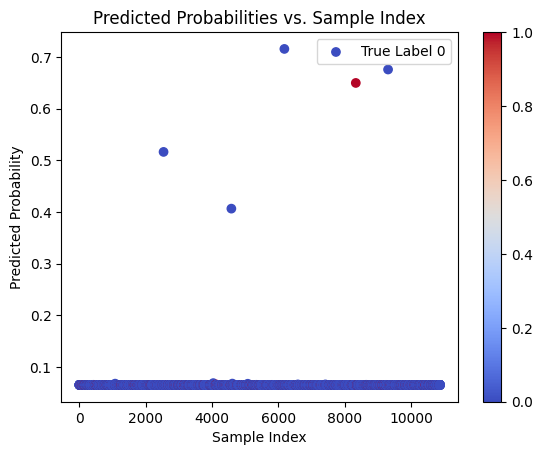

In [63]:
# plot the probabilities of the model and color each point by the true label, and add legend to the plot:
plt.scatter(range(len(test_eval_results['probabilities'])), test_eval_results['probabilities'], c=test_eval_results['lables'], cmap='coolwarm')
plt.colorbar()
plt.xlabel('Sample Index')
plt.ylabel('Predicted Probability')
plt.title('Predicted Probabilities vs. Sample Index')
plt.legend(['True Label 0', 'True Label 1'], loc='upper right')
plt.show()


maybe add class weight and use BCEWithLogitLoss, need to add pos_weight argument. 

## Add weight dropouts and :

In [98]:
import torch.nn.functional as F

class EnhancedMLPModelNN(nn.Module):
    def __init__(self, input_dim, one_hot_idx, one_hot_dim):
        super(EnhancedMLPModelNN, self).__init__()
        
        # Locally connected layer for one-hot encoded features
        self.local_fc = nn.Linear(np.sum(one_hot_idx), one_hot_dim)  # One-hot encoding dimension
        self.input_dim = input_dim
        self.one_hot_dim = one_hot_dim
        self.one_hot_idx = one_hot_idx
        
        # Fully connected layers
        self.fc1 = nn.Linear(input_dim - np.sum(one_hot_idx) + one_hot_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 4)
        self.fc5 = nn.Linear(4, 2)
        self.output = nn.Linear(2, 1)
        
        # Dropout layers
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.3)

    def forward(self, features):
        # Split features into numeric and one-hot parts
        numeric_features = features[:, ~self.one_hot_idx]
        one_hot_features = features[:, self.one_hot_idx]

        # Process one-hot encoded features with a locally connected layer
        one_hot_out = F.relu(self.local_fc(one_hot_features))
        
        # Concatenate back the numeric features
        x = torch.cat((numeric_features, one_hot_out), dim=1)

        # Forward pass with skip connections
        x1 = F.relu(self.fc1(x))
        x1 = self.dropout1(x1)

        x2 = F.relu(self.fc2(x1))
        x2 = self.dropout2(x2 + x1)  # Skip connection from x1 to x2

        x3 = F.relu(self.fc3(x2))
        x3 = self.dropout3(x3 + x2)  # Skip connection from x2 to x3

        x4 = F.relu(self.fc4(x3))
        x5 = F.relu(self.fc5(x4))

        # Output layer
        output = torch.sigmoid(self.output(x5))
        
        return output


In [87]:
one_hot_idx = np.where(X_train.columns.str.startswith('hug') | X_train.columns.str.startswith('faculty'))[0]
one_hot_idx = X_train.columns.str.startswith('hug') | X_train.columns.str.startswith('faculty')

In [88]:
len(one_hot_idx)

144

In [89]:
X_train.shape

(43476, 144)

In [99]:
model = EnhancedMLPModelNN(input_dim=X_train.shape[1], one_hot_idx=one_hot_idx, one_hot_dim=12)
criterion = nn.BCELoss()  # For binary classification
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0001)

In [100]:
train_model(model, train_loader, criterion, optimizer, epochs=10, device=device)

RuntimeError: The size of tensor a (16) must match the size of tensor b (32) at non-singleton dimension 1